## Helper functions

In [1]:
from cot import Collection

In [2]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [3]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [4]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [5]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [6]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [7]:
#Add minimal value and average value
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue
        if flag == True:

            data = new_dict

            # Find the lowest value
            lowest_value = min(data.values())

            # Calculate the average value
            average_value = sum(data.values()) / len(data)

            # Find the key(s) of the lowest value
            lowest_keys = [key for key, value in data.items() if value == lowest_value]     
            lowest_obj.append(lowest_keys)

            # Add lowest and average values to the dictionary
            data['lowest'] = lowest_value
            data['average'] = average_value

            scores_per_item.append(data)

    #get lowest keys split for true and false
    item_correct = []

    for item in new_data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = lowest_obj
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]
         
    return scores_per_item, variables_per_item, [scores_true,scores_false]

def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [8]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [9]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [10]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [11]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [12]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

# def avg_item_plot(scores_per_objective):  #later better axes
 
#     data = scores_per_objective
#     averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
#     sorted_data = {k: v for k, v in sorted(averaged_data.items())}

#     # Extract the keys (objectives) and values (averages) from the sorted dictionary
#     keys = sorted_data.keys()
#     values = sorted_data.values()

#     # Create a bar plot
#     plt.bar(keys, values)
#     plt.xlabel('Objectives')
#     plt.ylabel('Average')
#     # plt.ylim(7,10)
#     plt.title('Average per Objective')
#     plt.xticks(rotation=45)
#     plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


# def lowest_obj_true_false(data,dataset,split):
#     # Find the key(s) of the lowest value
#     lowest_obj = []
#     lowest_keys = [key for key, value in data.items() if value == ]     
#     lowest_obj.append(lowest_keys)

#     item_correct = []
#     for item in data[dataset][split]:
#         item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

#     # Example lists of scores and indicators
#     scores = average_per_item
#     indicators = item_correct

#     # Separate scores based on indicators
#     scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
#     scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

#     print("scores true:", statistics.mean(scores_true))
#     print("scores false:", statistics.mean(scores_false))

In [13]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [14]:
def t_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        t_stat, p_val = ttest_ind(dict_1[key], dict_2[key])
        print(f"For {key}, t-statistic is {t_stat:.2f} and the p-value is {p_val:.2f}")

In [15]:
from scipy.stats import mannwhitneyu

def u_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

## Data

In [28]:
from cot import Collection
med_qa = Collection(["med_qa"], verbose=False)

Loading med_qa...


In [29]:
# Determine sample size 
med_qa = med_qa.select(split="test", number_samples=1, random_samples=True, seed=0)

In [41]:

med_qa_turbo = Collection.from_json("./prelim_output/med_qa_zhou_eval_chatgpt.json")
med_qa_gpt_4 = Collection.from_json("./prelim_output/med_qa_zhou_eval_gpt4.json")

In [5]:
med_qa_cohere = Collection.from_json("./prelim_output/med_qa_zhou_cohere.json")
med_qa_cohere

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [6]:
med_qa_cohere_400 = Collection.from_json("./med_qa_400_zhou_cohere.json")
med_qa_cohere_400

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    400 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [7]:
cohere_500 = med_qa_cohere.merge(med_qa_cohere_400)
cohere_500

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [42]:
med_qa_gpt_4

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [30]:
#med_qa_cohere = med_qa = med_qa_cohere.select(split="test", number_samples=7, random_samples=True, seed=0)

In [104]:
from cot import Collection
med_qa_ts_100 = Collection.load_thoughtsource_100(names=['med_qa'],load_pregenerated_cots=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertpraas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/100 [00:00<?, ?ex/s]

In [120]:
from cot import Collection
med_qa = Collection(["med_qa"], verbose=False)
# Determine sample size 
med_qa = med_qa.select(split="test", number_samples=600, random_samples=True, seed=99)


Loading med_qa...


In [121]:
from numpy import loadtxt, savetxt
ts_100_ids = loadtxt("/Users/robertpraas/Desktop/ThoughtSource/notebooks/internal_documentation/paper_2/thoughtsource_100_ids.txt", dtype=str, comments="#", delimiter=",", unpack=False)
med_qa = med_qa.filter(lambda ex: ex['id'] not in ts_100_ids)
# then merge it



Loading cached processed dataset at /var/folders/wq/slcg80w1143270jpznm3k9hm0000gn/T/tmp4cu4rs55/cache-c12d68b3edf27cc8.arrow


In [127]:
med_qa = med_qa.select(split="test", number_samples=400, random_samples=True, seed=1998)

In [132]:
med_qa.dump("med_qa_400")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [129]:
med_qa_ts_100

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [130]:
test = med_qa.merge(med_qa_ts_100)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [131]:
test

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

## Generate extra data

In [29]:
from cot import Collection
med_qa_400 = Collection.from_json("med_qa_400.json")
med_qa_100 = Collection.from_json("med_qa_zhou.json")
med_qa_500 = med_qa_400.merge(med_qa_100)
med_qa_500
# gpt-3.5-turbo-0613

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [31]:
med_qa = med_qa_500
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo-0613", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
med_qa.dump("med_qa_500_turbo-0613")
med_qa.evaluate()
med_qa.dump("med_qa_400_turbo-0613_eval")
med_qa.evaluate()

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d9c6f8bc4b53664f5cefb6ca952d7093 in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7894dd66f9a9bfca9180656ba909060f in your message.).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can r

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'gpt-3.5-turbo': {'None_zhou-01_kojima-A-E': 0.58},
    'gpt-3.5-turbo-0613': {'None_zhou-01_kojima-A-E': 0.63}}}}}

In [ ]:
# generate cohere
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "cohere",
    "api_time_interval": 1,
    "engine": "command-xlarge-nightly", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

# med_qa.dump("med_qa_zhou_cohere.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_cohere.json")

In [31]:
# generate gpt-3.5-turbo
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
# med_qa.dump("med_qa_zhou.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_eval.json")

Generating med_qa...


In [42]:
from cot import Collection
# med_qa = Collection.from_json("med_qa_400.json")

# generate gpt-4
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-4", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

med_qa.dump("med_qa_400_gpt4.json")
med_qa.evaluate()
med_qa.dump("med_qa_400_eval_gpt4.json")

med_qa.evaluate()

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Request failed due to server shutdown {
  "error": {
    "message": "Request failed due to server shutdown",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'Request failed due to server shutdown', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Fri, 02 Jun 2023 21:49:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '141', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-0314', 'openai-organization': 'medical-university-of-vienna', 'openai-processing-ms': '32142', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '200', 'x-ratelimit-limit-tokens': '40000', 'x-ratelimit-remaining-requests': '199', 'x-ratelimit-remaining-tokens': '39192', 'x-ratelimit-rese

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'gpt-4': {'None_zhou-01_kojima-A-E': 0.785}}}}}

## Template

In [16]:
path = "./final_system_messages/first_template.yaml"

## Run Reflection

In [19]:
# gpt-3.5-turbo reflects on cohere 
med_qa_cohere = Collection.from_json("./prelim_output/med_qa_zhou_cohere.json")
med_qa_cohere_400 = Collection.from_json("./med_qa_400_zhou_cohere.json")
cohere_500 = med_qa_cohere.merge(med_qa_cohere_400)
data = cohere_500 #med_qa_cohere
model = 'gpt-3.5-turbo-0613'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "cohere"
critique_model = "gpt-3.5-turbo-0613"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")




Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

(API-)Error in item 93: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 27a0f22969e99c7ee3521b1e596f01f1 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 183: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4f94e982666644fba1c65f92c410b8c0 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 416: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 8d03ee86f17c43f3394242560120f28a in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
# 3.5 on 3.5
med_qa_turbo_100 = Collection.from_json("./prelim_output/med_qa_zhou_eval_chatgpt.json")
med_qa_turbo_400 = Collection.from_json("./med_qa_400_turbo_eval.json")

med_qa_500 = med_qa_turbo_100.merge(med_qa_turbo_400)
med_qa_500

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    500 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [23]:
# 3.5 on 3.5

data = med_qa_500
model = 'gpt-3.5-turbo-0613'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo-0613"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

(API-)Error in item 238: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID b9faeb6d98a870e07ab7bbaa7e300c75 in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
# 3.5 on 3.5 both new
data = Collection.from_json("./med_qa_500_turbo-0613.json")
model = 'gpt-3.5-turbo-0613'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo-0613"
critique_model = "gpt-3.5-turbo-0613"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

(API-)Error in item 250: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0e4ec0fc26d8b69b3d4acf6fce3f8f05 in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [24]:
med_qa_gpt_4 = Collection.from_json("./prelim_output/med_qa_zhou_eval_gpt4.json")
med_qa_gpt_4_400 = Collection.from_json("med_qa_400_eval_gpt4.json")
data = med_qa_gpt_4.merge(med_qa_gpt_4_400)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [25]:
#3.5 on 4
model = 'gpt-3.5-turbo-0613'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-4"
critique_model = "gpt-3.5-turbo-0613"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

(API-)Error in item 286: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 0b17254b7dbc4a560c0feda93f8df637 in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
# gpt-4 reflects on cohere 
data = cohere_500 #med_qa_cohere
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "cohere"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/500 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
# 3.5 on 3.5
med_qa_turbo = Collection.from_json("./prelim_output/med_qa_zhou_eval_chatgpt.json")
#/Users/robertpraas/ThoughtSource/notebooks/reflection_messages/med_qa_400_turbo_eval.json

cohere_500 = med_qa_cohere.merge(med_qa_cohere_400)
data = med_qa
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

# dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
# data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

(API-)Error in item 149: Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Retrying with additional time of 10 seconds.


In [40]:
dump_path = f"{dataset_name}_400_{template}_{base_model}_{critique_model}"
med_qa.dump(dump_path+".json")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# 4 on 3.5
data = med_qa
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_400_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

In [3]:
from cot import Collection
data = Collection.from_json("/Users/robertpraas/ThoughtSource/notebooks/reflection_messages/prelim_output/med_qa_zhou_eval_gpt4.json")
data

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [10]:
#3.5 on 4 also run on 100
med_qa_gpt_4 = Collection.from_json("./prelim_output/med_qa_zhou_eval_gpt4.json")
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-4"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_100_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 40: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 8558c0df0f54fde504eddbfdc65233ec in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [45]:
# 4 on 3.5
data = Collection.from_json("med_qa_400_turbo_eval.json")
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_400_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

(API-)Error in item 76: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sat, 03 Jun 2023 01:54:45 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7d144780de511af8-AMS', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time of 10 seconds.
(API-)Error in item 157: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sat, 03 Jun 2023 02:20:44 GMT', 'Content-Type': 'application/json', 'C

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
# 4 on 4 - if costs allow
data = Collection.from_json("med_qa_400_eval_gpt4.json")
model = "gpt-4"
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-4"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_400_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
## second template
path = "./final_system_messages/first_template.yaml"

In [49]:
# gpt-3.5-turbo reflects on cohere 
data = med_qa_cohere
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "cohere"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Second

In [50]:
# 3.5 on 3.5
data = med_qa_turbo
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 52: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
# 4 on 3.5
#data = med_qa_turbo
model = 'gpt-4'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "second"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-4"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 2: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6fdf52136ded5e058c274272f987da5a in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 2: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 20 seconds.
(API-)Error in item 5: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 5: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 20 seconds.
(API-)Error in item 14: The server had an error while processing your request. Sorry about that!
Retrying with additional time of 10 seconds.
(API-)Error in item 14: The server had an error while processing your request. Sorry about that!
Retrying with additional

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## third template

In [84]:
# gpt-3.5-turbo reflects on cohere 
data = med_qa_cohere
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "third"
base_model = "cohere"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 13: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 11821c37defb8249cbc6380a23584c90 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 85: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID bfb19e08df1f5fcc4caf5fc23ee6898a in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [85]:
# 3.5 on 3.5
data = med_qa_turbo
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "third"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Evaluate Reflection

        Average
obj_1     59.00
obj_2     75.50
obj_3     59.10
obj_4     52.15
obj_5     55.70
obj_6     55.05
obj_7     52.05
obj_8     60.00
obj_9     36.60
obj_10    58.70
obj_11    63.50
scores true: 61.81818181818182
scores false: 54.779411764705884


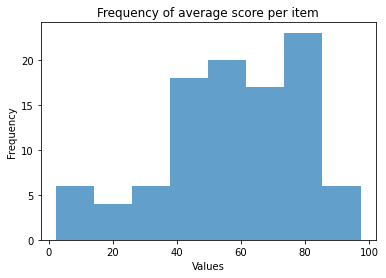

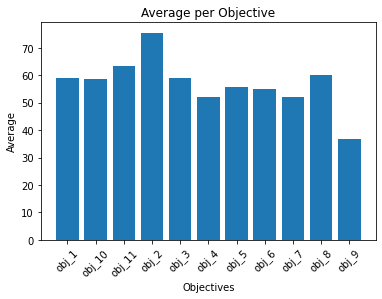

{'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_2': (25, 100), 'obj_9': (0, 80), 'obj_5': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_1': (0, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 22.24172755080965, 'obj_8': 25.34608929251695, 'obj_4': 23.871023387692382, 'obj_2': 18.16729217716567, 'obj_9': 25.848040779161803, 'obj_5': 19.18832768096062, 'obj_7': 21.20242743869034, 'obj_10': 21.551207517318968, 'obj_1': 23.148619523820116, 'obj_11': 35.230123703467406, 'obj_3': 27.278770374254627}
For obj_6, t-statistic is 1.24 and the p-value is 0.22
For obj_8, t-statistic is 1.97 and the p-value is 0.05
For obj_4, t-statistic is 1.59 and the p-value is 0.11
For obj_2, t-statistic is 0.81 and the p-value is 0.42
For obj_9, t-statistic is 1.24 and the p-value is 0.22
For obj_5, t-statistic is 0.75 and the p-value is 0.45
For obj_7, t-statistic is 1.16 and the p-value is 0.25
For obj_10, t-statistic is 1.42 and the p-value is 0.16
For obj_1, t-statistic is 1.41

In [71]:
data = Collection.from_json("./med_qa_first_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


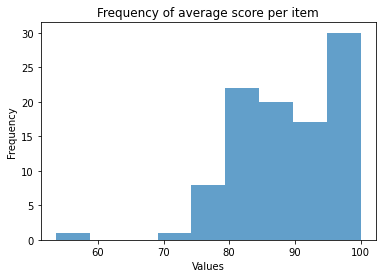

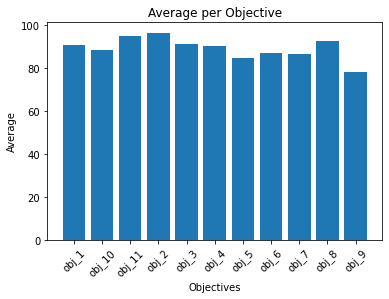

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [72]:
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


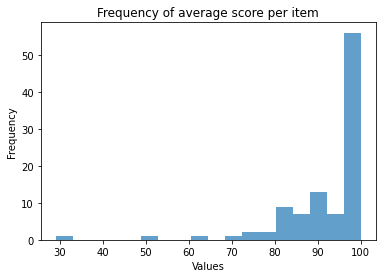

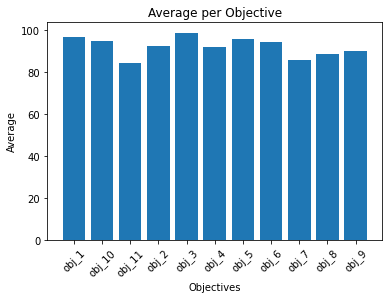

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [142]:
#note idx-2 
data = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     99.45
obj_2     98.30
obj_3    100.00
obj_4     98.20
obj_5     99.50
obj_6     98.30
obj_7     90.50
obj_8     97.95
obj_9     93.90
obj_10    99.15
obj_11    98.50
scores true: 97.96857463524131
scores false: 96.10047846889952


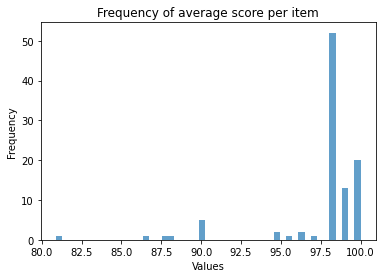

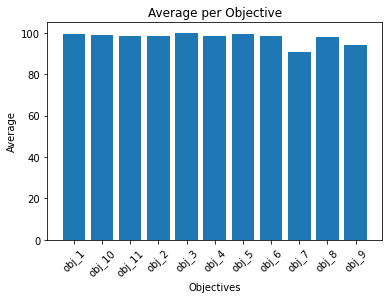

{'obj_6': (70, 100), 'obj_8': (70, 100), 'obj_4': (70, 100), 'obj_2': (70, 100), 'obj_9': (70, 100), 'obj_5': (90, 100), 'obj_7': (60, 100), 'obj_10': (80, 100), 'obj_1': (90, 100), 'obj_11': (50, 100), 'obj_3': (100, 100)}
{'obj_6': 5.135536717202729, 'obj_8': 5.90732296784801, 'obj_4': 5.389852043470677, 'obj_2': 5.135536717202729, 'obj_9': 5.84220105194208, 'obj_5': 2.190429135575903, 'obj_7': 7.571210756756962, 'obj_10': 3.557251804980975, 'obj_1': 2.2355032425551866, 'obj_11': 7.571210756756962, 'obj_3': 0.0}
For obj_6, t-statistic is 2.98 and the p-value is 0.00
For obj_8, t-statistic is 1.79 and the p-value is 0.08
For obj_4, t-statistic is 2.21 and the p-value is 0.03
For obj_2, t-statistic is 2.43 and the p-value is 0.02
For obj_9, t-statistic is 0.18 and the p-value is 0.86
For obj_5, t-statistic is 2.44 and the p-value is 0.02
For obj_7, t-statistic is 2.40 and the p-value is 0.02
For obj_10, t-statistic is 2.10 and the p-value is 0.04
For obj_1, t-statistic is 2.28 and the 

In [74]:
# Very low p-values - what is going on? Either mistake in code or a real difference?
data = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     59.00
obj_2     75.50
obj_3     59.10
obj_4     52.15
obj_5     55.70
obj_6     55.05
obj_7     52.05
obj_8     60.00
obj_9     36.60
obj_10    58.70
obj_11    63.50
scores true: 61.81818181818182
scores false: 54.779411764705884


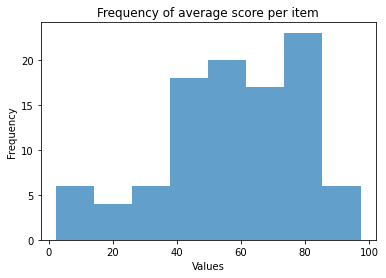

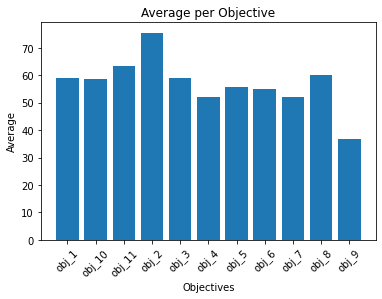

{'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_2': (25, 100), 'obj_9': (0, 80), 'obj_5': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_1': (0, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 22.24172755080965, 'obj_8': 25.34608929251695, 'obj_4': 23.871023387692382, 'obj_2': 18.16729217716567, 'obj_9': 25.848040779161803, 'obj_5': 19.18832768096062, 'obj_7': 21.20242743869034, 'obj_10': 21.551207517318968, 'obj_1': 23.148619523820116, 'obj_11': 35.230123703467406, 'obj_3': 27.278770374254627}
For obj_6, t-statistic is 1.24 and the p-value is 0.22
For obj_8, t-statistic is 1.97 and the p-value is 0.05
For obj_4, t-statistic is 1.59 and the p-value is 0.11
For obj_2, t-statistic is 0.81 and the p-value is 0.42
For obj_9, t-statistic is 1.24 and the p-value is 0.22
For obj_5, t-statistic is 0.75 and the p-value is 0.45
For obj_7, t-statistic is 1.16 and the p-value is 0.25
For obj_10, t-statistic is 1.42 and the p-value is 0.16
For obj_1, t-statistic is 1.41

In [78]:
data = Collection.from_json("./med_qa_second_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


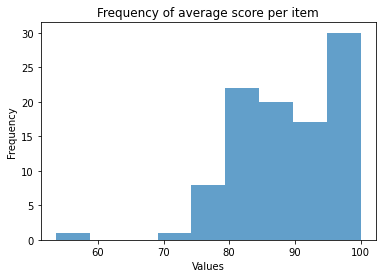

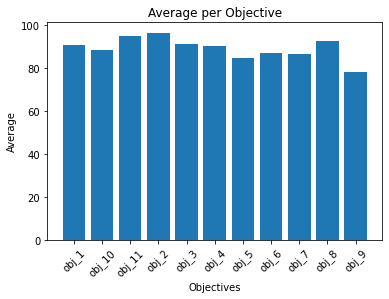

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [75]:
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1     96.60
obj_2     92.40
obj_3     98.70
obj_4     92.00
obj_5     95.90
obj_6     94.10
obj_7     85.70
obj_8     88.60
obj_9     89.80
obj_10    94.75
obj_11    84.40
scores true: 96.40282131661442
scores false: 86.12554112554113


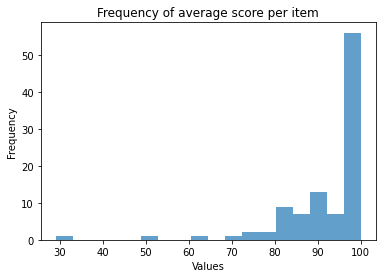

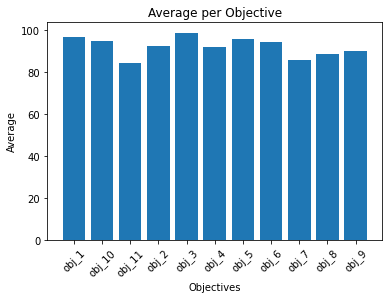

{'obj_6': (30, 100), 'obj_8': (20, 100), 'obj_4': (40, 100), 'obj_2': (40, 100), 'obj_9': (0, 100), 'obj_5': (60, 100), 'obj_7': (30, 100), 'obj_10': (40, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (0, 100)}
{'obj_6': 11.200198410940953, 'obj_8': 17.131104677595868, 'obj_4': 12.949006435891816, 'obj_2': 11.730991501836568, 'obj_9': 13.1794146189036, 'obj_5': 8.052228501376751, 'obj_7': 12.165109904554864, 'obj_10': 9.933490948515654, 'obj_1': 8.067893720848657, 'obj_11': 32.76238296238138, 'obj_3': 10.215357818184128}
For obj_6, t-statistic is 4.37 and the p-value is 0.00
For obj_8, t-statistic is 6.10 and the p-value is 0.00
For obj_4, t-statistic is 5.16 and the p-value is 0.00
For obj_2, t-statistic is 5.03 and the p-value is 0.00
For obj_9, t-statistic is 1.26 and the p-value is 0.21
For obj_5, t-statistic is 2.80 and the p-value is 0.01
For obj_7, t-statistic is 3.70 and the p-value is 0.00
For obj_10, t-statistic is 3.92 and the p-value is 0.00
For obj_1, t-statistic 

In [143]:
#note idx_cot
data = Collection.from_json("./med_qa_second_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      5.19
obj_2      6.48
obj_3      5.61
obj_4      4.29
obj_5      4.81
obj_6      5.08
obj_7      4.47
obj_8      5.46
obj_9      3.28
obj_10     5.04
obj_11     5.50
scores true: 5.3352272727272725
scores false: 4.870320855614973


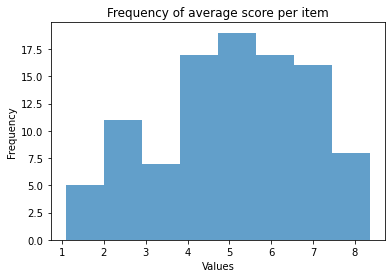

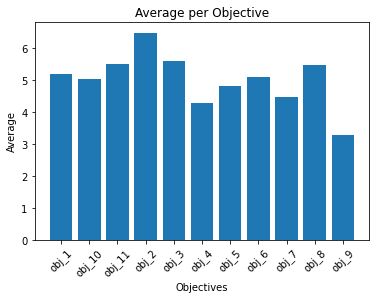

{'obj_6': (2, 8), 'obj_8': (1, 9), 'obj_4': (1, 9), 'obj_2': (2, 10), 'obj_9': (0, 7), 'obj_5': (1, 8), 'obj_7': (1, 8), 'obj_10': (1, 8), 'obj_1': (2, 8), 'obj_11': (0, 10), 'obj_3': (0, 9)}
{'obj_6': 1.6798268309019782, 'obj_8': 2.2175607675046374, 'obj_4': 1.881837700577054, 'obj_2': 2.1200343050397685, 'obj_9': 1.7001485377769348, 'obj_5': 1.4612503294276875, 'obj_7': 1.6603212540549697, 'obj_10': 1.8744426781140449, 'obj_1': 2.0631201240995747, 'obj_11': 2.886751345948129, 'obj_3': 2.1456792383623875}
For obj_6, t-statistic is 0.69 and the p-value is 0.49
For obj_8, t-statistic is 1.69 and the p-value is 0.09
For obj_4, t-statistic is 0.88 and the p-value is 0.38
For obj_2, t-statistic is 1.08 and the p-value is 0.28
For obj_9, t-statistic is 1.14 and the p-value is 0.26
For obj_5, t-statistic is 0.30 and the p-value is 0.76
For obj_7, t-statistic is 0.51 and the p-value is 0.61
For obj_10, t-statistic is 1.00 and the p-value is 0.32
For obj_1, t-statistic is 0.61 and the p-value 

In [139]:
data = Collection.from_json("./med_qa_third_cohere_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=5,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1      8.11
obj_2      9.32
obj_3      8.44
obj_4      8.34
obj_5      7.47
obj_6      8.09
obj_7      7.90
obj_8      8.95
obj_9      7.06
obj_10     8.19
obj_11     9.09
scores true: 8.33228840125392
scores false: 8.181818181818182


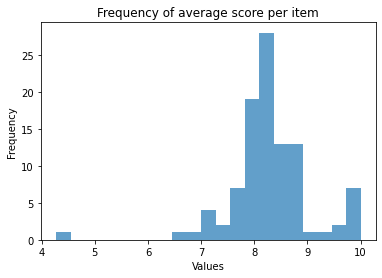

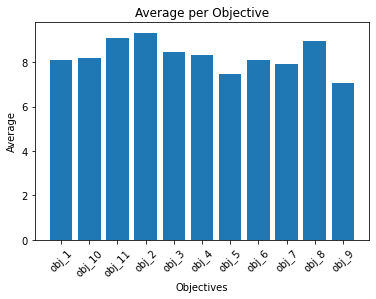

{'obj_6': (4, 10), 'obj_8': (5, 10), 'obj_4': (5, 10), 'obj_2': (6, 10), 'obj_9': (2, 10), 'obj_5': (4, 10), 'obj_7': (4, 10), 'obj_10': (3, 10), 'obj_1': (4, 10), 'obj_11': (5, 10), 'obj_3': (3, 10)}
{'obj_6': 0.888705789222721, 'obj_8': 0.7571210756756955, 'obj_4': 0.9235417115264979, 'obj_2': 0.6798692684790385, 'obj_9': 1.2294369245777328, 'obj_5': 1.0679443105822752, 'obj_7': 1.077782984471439, 'obj_10': 0.960797227895311, 'obj_1': 0.8027100562117262, 'obj_11': 0.9111542241585777, 'obj_3': 0.9777318630174611}
For obj_6, t-statistic is 1.32 and the p-value is 0.19
For obj_8, t-statistic is -0.03 and the p-value is 0.98
For obj_4, t-statistic is 0.72 and the p-value is 0.47
For obj_2, t-statistic is 1.33 and the p-value is 0.19
For obj_9, t-statistic is 0.41 and the p-value is 0.68
For obj_5, t-statistic is 0.71 and the p-value is 0.48
For obj_7, t-statistic is 1.47 and the p-value is 0.14
For obj_10, t-statistic is -0.00 and the p-value is 1.00
For obj_1, t-statistic is 0.41 and th

In [141]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=6,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [100]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt

power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=.4, power=0.9, alpha=0.05,ratio=0.67)
sample_size

164.84701057007064

          Average
obj_1   90.454545
obj_2   96.262626
obj_3   91.262626
obj_4   90.050505
obj_5   84.343434
obj_6   86.767677
obj_7   86.161616
obj_8   92.373737
obj_9   78.181818
obj_10  88.080808
obj_11  94.949495
scores true: 89.78056426332289
scores false: 87.87139689578714


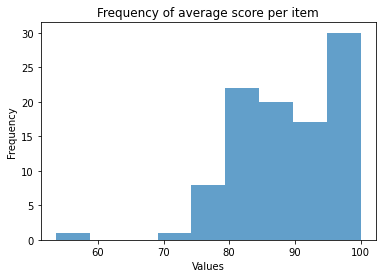

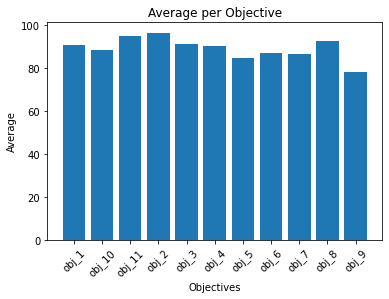

{'obj_6': (50, 100), 'obj_8': (60, 100), 'obj_4': (50, 100), 'obj_2': (60, 100), 'obj_9': (40, 100), 'obj_5': (50, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_3': (50, 100)}
{'obj_6': 9.982462461357615, 'obj_8': 7.770412037752322, 'obj_4': 9.271828890074005, 'obj_2': 5.9907852004623585, 'obj_9': 12.62598845301168, 'obj_5': 12.17739761093177, 'obj_7': 11.754900906453967, 'obj_10': 9.441200165489128, 'obj_1': 10.103820985932504, 'obj_11': 12.807343028770916, 'obj_3': 9.485311801471786}
For obj_6, t-statistic is 0.46 and the p-value is 0.65
For obj_8, t-statistic is 1.38 and the p-value is 0.17
For obj_4, t-statistic is 0.59 and the p-value is 0.55
For obj_2, t-statistic is 0.91 and the p-value is 0.36
For obj_9, t-statistic is 0.73 and the p-value is 0.47
For obj_5, t-statistic is 0.97 and the p-value is 0.33
For obj_7, t-statistic is 1.80 and the p-value is 0.07
For obj_10, t-statistic is 1.11 and the p-value is 0.27
For obj_1, t-statistic

In [88]:
data = Collection.from_json("./med_qa_third_gpt-3.5-turbo_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

In [ ]:
# Average objective score
# Average item score (variance,span) - finding outliers?
# average objectives/item scores per true and false answers
# split range up for true, false?

        Average
obj_1   97.2000
obj_2   90.1750
obj_3   98.7000
obj_4   90.5125
obj_5   94.2875
obj_6   92.0000
obj_7   83.4250
obj_8   88.2750
obj_9   88.1000
obj_10  93.1000
obj_11  88.1500
scores true: 95.80123266563945
scores false: 84.73946784922394


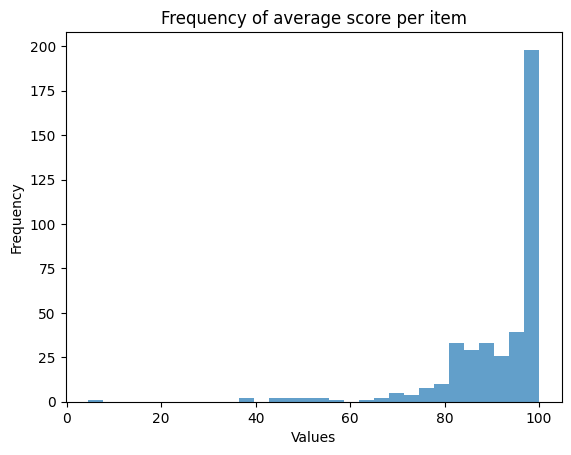

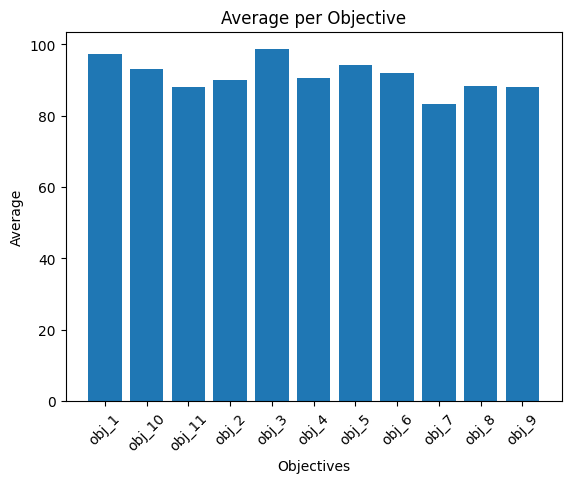

{'obj_11': (0, 100), 'obj_3': (0, 100), 'obj_10': (0, 100), 'obj_4': (0, 100), 'obj_1': (50, 100), 'obj_8': (0, 100), 'obj_7': (0, 100), 'obj_2': (0, 100), 'obj_5': (0, 100), 'obj_6': (0, 100), 'obj_9': (0, 100)}
{'obj_11': 27.703722504412585, 'obj_3': 7.935201229103485, 'obj_10': 12.476142646601405, 'obj_4': 14.511246826553243, 'obj_1': 6.144459778118202, 'obj_8': 17.270496522257712, 'obj_7': 14.510194324969202, 'obj_2': 13.010286079085606, 'obj_5': 10.763106191393751, 'obj_6': 12.738944295128462, 'obj_9': 15.394234509723157}
For obj_11, t-statistic is 9.23 and the p-value is 0.00
For obj_3, t-statistic is 2.54 and the p-value is 0.01
For obj_10, t-statistic is 9.60 and the p-value is 0.00
For obj_4, t-statistic is 10.61 and the p-value is 0.00
For obj_1, t-statistic is 7.62 and the p-value is 0.00
For obj_8, t-statistic is 12.50 and the p-value is 0.00
For obj_7, t-statistic is 8.00 and the p-value is 0.00
For obj_2, t-statistic is 10.65 and the p-value is 0.00
For obj_5, t-statistic

In [17]:
from cot import Collection
data = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

          Average
obj_1   90.388471
obj_2   96.328321
obj_3   92.431078
obj_4   89.498747
obj_5   83.972431
obj_6   86.102757
obj_7   85.463659
obj_8   92.481203
obj_9   76.566416
obj_10  87.719298
obj_11  96.027569
scores true: 88.87955993051534
scores false: 88.58288770053476


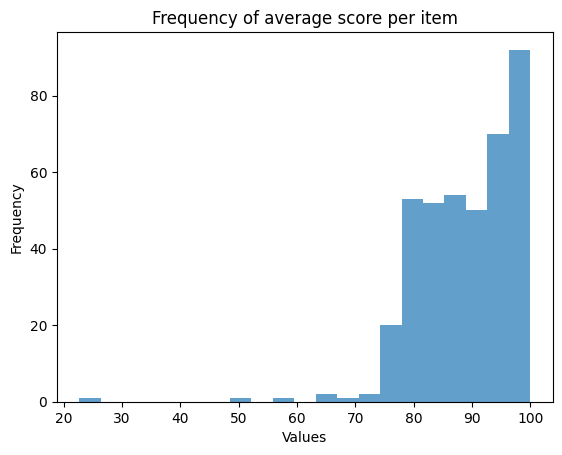

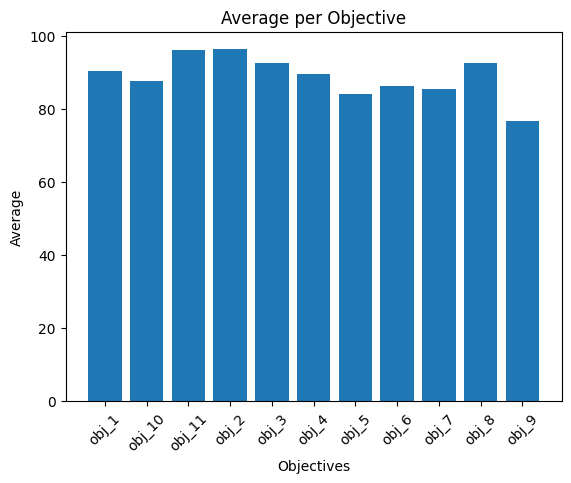

{'obj_11': (0, 100), 'obj_3': (0, 100), 'obj_10': (50, 100), 'obj_4': (20, 100), 'obj_1': (30, 100), 'obj_8': (20, 100), 'obj_7': (30, 100), 'obj_2': (40, 100), 'obj_5': (40, 100), 'obj_6': (20, 100), 'obj_9': (0, 100)}
{'obj_11': 8.872165375311182, 'obj_3': 9.336244636417469, 'obj_10': 9.225614522913844, 'obj_4': 10.278746840771332, 'obj_1': 10.256115587946198, 'obj_8': 8.15114891901078, 'obj_7': 12.348501328884316, 'obj_2': 6.148495337227046, 'obj_5': 11.848997237416278, 'obj_6': 10.365771244146554, 'obj_9': 13.421649612807991}
For obj_11, t-statistic is -0.24 and the p-value is 0.81
For obj_3, t-statistic is 0.35 and the p-value is 0.73
For obj_10, t-statistic is 0.61 and the p-value is 0.54
For obj_4, t-statistic is 0.62 and the p-value is 0.53
For obj_1, t-statistic is -0.74 and the p-value is 0.46
For obj_8, t-statistic is 0.09 and the p-value is 0.93
For obj_7, t-statistic is 0.49 and the p-value is 0.63
For obj_2, t-statistic is 0.16 and the p-value is 0.88
For obj_5, t-statist

In [18]:
data = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

        Average
obj_1   99.4500
obj_2   97.4875
obj_3   99.7750
obj_4   98.2500
obj_5   98.9875
obj_6   98.4375
obj_7   89.7500
obj_8   97.7375
obj_9   92.7375
obj_10  98.9125
obj_11  97.6000
scores true: 97.78807180081066
scores false: 95.02114164904863


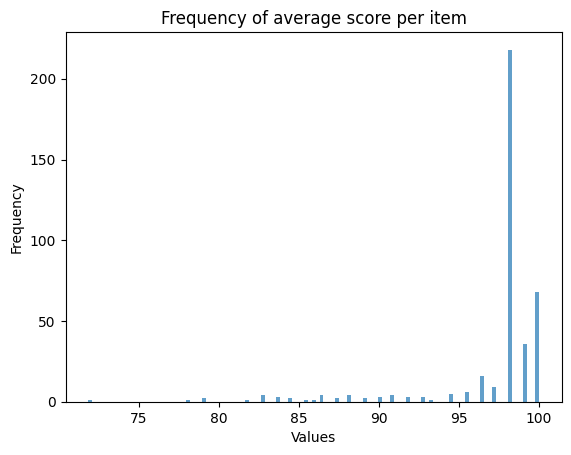

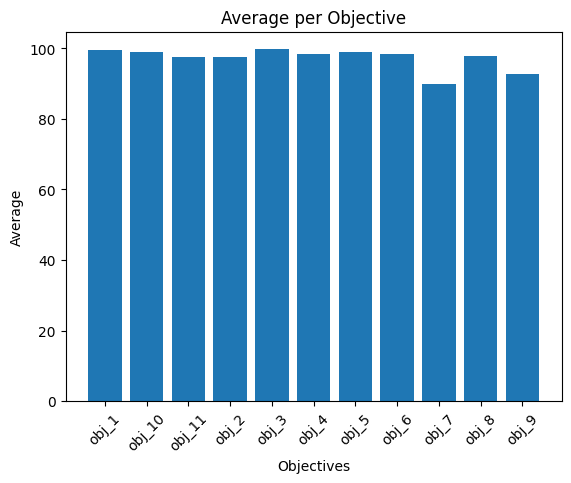

{'obj_11': (0, 100), 'obj_3': (40, 100), 'obj_10': (80, 100), 'obj_4': (70, 100), 'obj_1': (80, 100), 'obj_8': (50, 100), 'obj_7': (50, 100), 'obj_2': (70, 100), 'obj_5': (70, 100), 'obj_6': (80, 100), 'obj_9': (60, 100)}
{'obj_11': 13.025519582765266, 'obj_3': 3.3507377708532387, 'obj_10': 3.5933444115684763, 'obj_4': 5.443949988629281, 'obj_1': 2.3899329381013064, 'obj_8': 6.923759083736537, 'obj_7': 7.719227044556568, 'obj_2': 5.88101262741457, 'obj_5': 3.882657766056732, 'obj_6': 4.788362432707806, 'obj_9': 6.197953720851292}
For obj_11, t-statistic is 5.14 and the p-value is 0.00
For obj_3, t-statistic is 1.48 and the p-value is 0.14
For obj_10, t-statistic is 4.20 and the p-value is 0.00
For obj_4, t-statistic is 5.18 and the p-value is 0.00
For obj_1, t-statistic is 3.23 and the p-value is 0.00
For obj_8, t-statistic is 5.86 and the p-value is 0.00
For obj_7, t-statistic is 3.99 and the p-value is 0.00
For obj_2, t-statistic is 4.87 and the p-value is 0.00
For obj_5, t-statistic

In [19]:
data = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

t_test(data,scores_per_item,'med_qa','test')

## 500 samples dataset

          Average
obj_1   90.388471
obj_2   96.328321
obj_3   92.431078
obj_4   89.498747
obj_5   83.972431
obj_6   86.102757
obj_7   85.463659
obj_8   92.481203
obj_9   76.566416
obj_10  87.719298
obj_11  96.027569
scores true: 88.87955993051534
scores false: 88.58288770053476


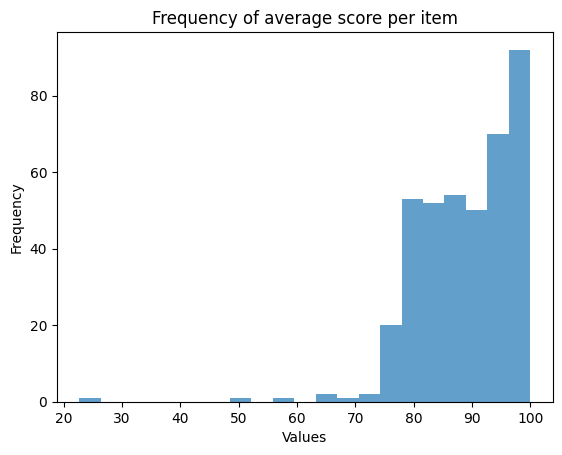

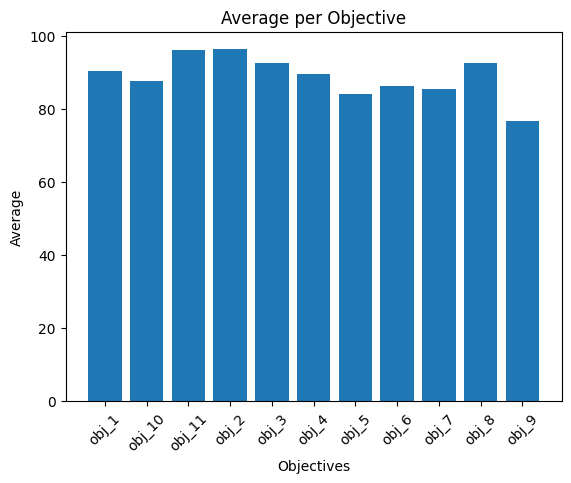

{'obj_3': (0, 100), 'obj_1': (30, 100), 'obj_11': (0, 100), 'obj_9': (0, 100), 'obj_6': (20, 100), 'obj_8': (20, 100), 'obj_4': (20, 100), 'obj_7': (30, 100), 'obj_10': (50, 100), 'obj_2': (40, 100), 'obj_5': (40, 100)}
{'obj_3': 9.336244636417469, 'obj_1': 10.256115587946198, 'obj_11': 8.872165375311182, 'obj_9': 13.421649612807991, 'obj_6': 10.365771244146554, 'obj_8': 8.15114891901078, 'obj_4': 10.278746840771332, 'obj_7': 12.348501328884316, 'obj_10': 9.225614522913844, 'obj_2': 6.148495337227046, 'obj_5': 11.848997237416278}
For obj_3, U-statistic is 13604.50 and the p-value is 0.77
For obj_1, U-statistic is 12891.50 and the p-value is 0.61
For obj_11, U-statistic is 14026.00 and the p-value is 0.37
For obj_9, U-statistic is 13974.50 and the p-value is 0.48
For obj_6, U-statistic is 13857.00 and the p-value is 0.57
For obj_8, U-statistic is 13692.00 and the p-value is 0.69
For obj_4, U-statistic is 14296.50 and the p-value is 0.29
For obj_7, U-statistic is 14019.00 and the p-value

In [29]:
#GPT-4: GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
#data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-3.5-turbo.json")
#data_500 = data_400.merge(data_100)
data = data_400 #data_500

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

          Average
obj_1   95.861723
obj_2   91.382766
obj_3   97.224449
obj_4   90.420842
obj_5   92.314629
obj_6   90.961924
obj_7   83.967936
obj_8   89.088176
obj_9   86.132265
obj_10  92.104208
obj_11  89.498998
scores true: 94.6134817563389
scores false: 85.36585365853658


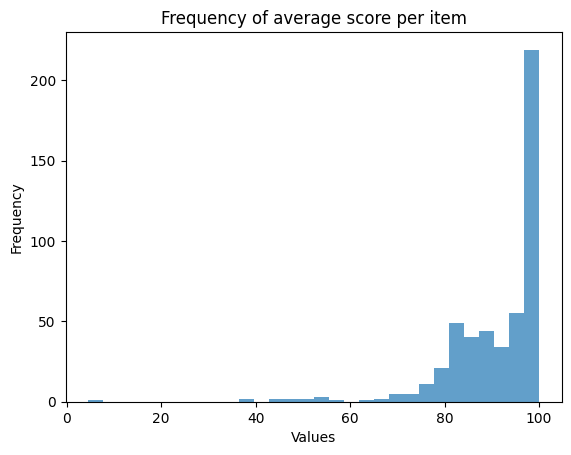

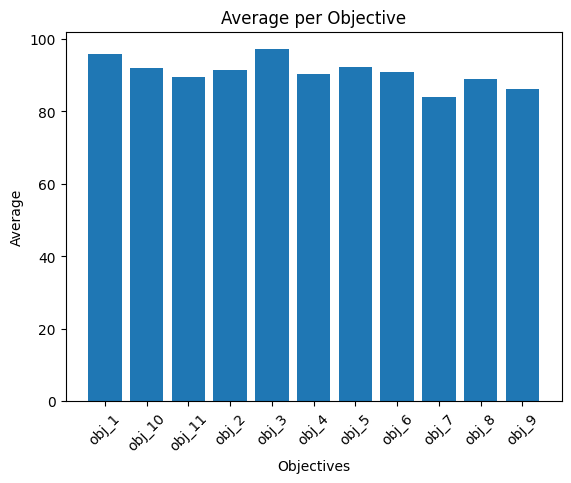

{'obj_3': (0, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_9': (0, 100), 'obj_6': (0, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_7': (0, 100), 'obj_10': (0, 100), 'obj_2': (0, 100), 'obj_5': (0, 100)}
{'obj_3': 8.773232121305732, 'obj_1': 7.588759775840389, 'obj_11': 25.58452208031851, 'obj_9': 15.392147801327658, 'obj_6': 12.409372393437476, 'obj_8': 15.922762888171556, 'obj_4': 13.625927863214256, 'obj_7': 14.03835015406326, 'obj_10': 12.094057517375338, 'obj_2': 12.189590972606567, 'obj_5': 11.736874511813202}
For obj_3, U-statistic is 32299.00 and the p-value is 0.03
For obj_1, U-statistic is 38099.50 and the p-value is 0.00
For obj_11, U-statistic is 40116.00 and the p-value is 0.00
For obj_9, U-statistic is 34992.50 and the p-value is 0.00
For obj_6, U-statistic is 41815.50 and the p-value is 0.00
For obj_8, U-statistic is 48145.00 and the p-value is 0.00
For obj_4, U-statistic is 44255.50 and the p-value is 0.00
For obj_7, U-statistic is 41448.50 and the p-value is 0

In [26]:
#GPT-3.5: GPT-4

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
          Average
obj_1   88.878866
obj_2   95.399485
obj_3   90.244845
obj_4   87.641753
obj_5   82.074742
obj_6   85.141753
obj_7   84.033505
obj_8   91.481959
obj_9   77.010309
obj_10  86.881443
obj_11  94.948454
scores true: 88.2939787485242
scores false: 86.60972785176607


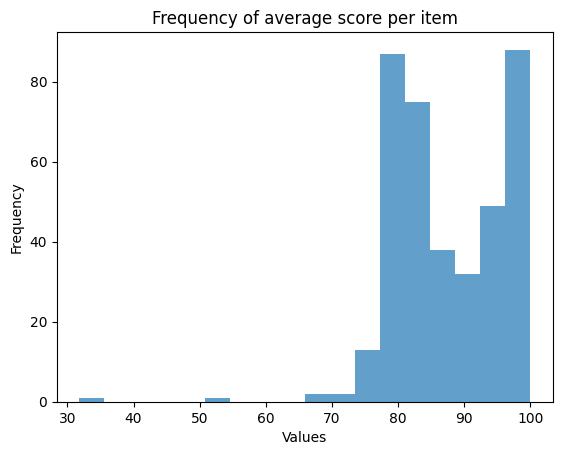

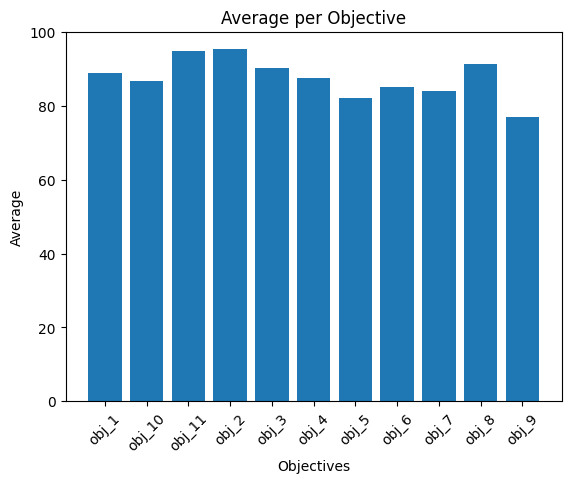

{'obj_3': (50, 100), 'obj_1': (50, 100), 'obj_11': (0, 100), 'obj_9': (0, 100), 'obj_6': (50, 100), 'obj_8': (0, 100), 'obj_4': (0, 100), 'obj_7': (50, 100), 'obj_10': (50, 100), 'obj_2': (50, 100), 'obj_5': (50, 100)}
{'obj_3': 9.711835089358658, 'obj_1': 9.689935467105503, 'obj_11': 9.078891819614393, 'obj_9': 13.160896465276684, 'obj_6': 10.00222244144176, 'obj_8': 8.659936819287815, 'obj_4': 10.524636239793159, 'obj_7': 12.385137841854249, 'obj_10': 9.28678124658062, 'obj_2': 6.01743373686309, 'obj_5': 12.237405324687476}
For obj_3, U-statistic is 20019.00 and the p-value is 0.07
For obj_1, U-statistic is 20060.50 and the p-value is 0.06
For obj_11, U-statistic is 19450.50 and the p-value is 0.16
For obj_9, U-statistic is 18831.50 and the p-value is 0.50
For obj_6, U-statistic is 18943.00 and the p-value is 0.43
For obj_8, U-statistic is 20166.50 and the p-value is 0.04
For obj_4, U-statistic is 20207.00 and the p-value is 0.04
For obj_7, U-statistic is 18679.00 and the p-value is 

In [27]:
#GPT-3.5: GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(df)

avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print(range_data)

print(standard_deviation(scores_per_objective))

scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Average over objectives for all items
        Average
obj_1     99.45
obj_2     97.65
obj_3     99.82
obj_4     98.24
obj_5     99.09
obj_6     98.41
obj_7     89.90
obj_8     97.78
obj_9     92.97
obj_10    98.96
obj_11    97.78


Average over objectives separated by items with correct / incorrect answers
scores true: 97.20173497388687
scores false: 94.15584415584416


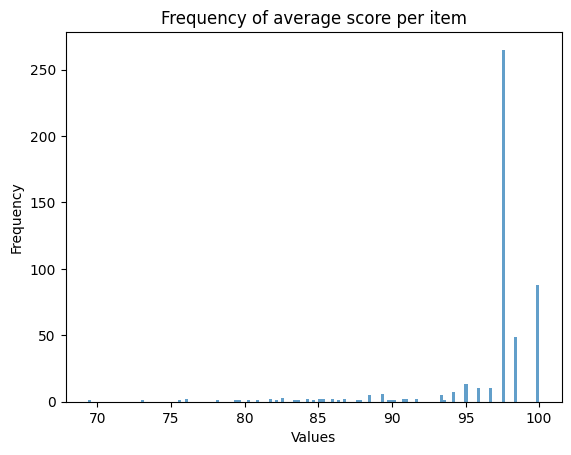

Mann-Whitney-U test
For obj_3, U-statistic is 20883.00 and the p-value is 0.31
For obj_1, U-statistic is 22583.00 and the p-value is 0.00
For obj_11, U-statistic is 22806.00 and the p-value is 0.00
For obj_9, U-statistic is 20835.50 and the p-value is 0.93
For obj_6, U-statistic is 24844.00 and the p-value is 0.00
For average, U-statistic is 26231.50 and the p-value is 0.00
For obj_8, U-statistic is 25495.50 and the p-value is 0.00
For obj_4, U-statistic is 24507.50 and the p-value is 0.00
For obj_7, U-statistic is 25066.50 and the p-value is 0.00
For obj_10, U-statistic is 23527.50 and the p-value is 0.00
For lowest, U-statistic is 25841.50 and the p-value is 0.00
For obj_2, U-statistic is 24847.50 and the p-value is 0.00
For obj_5, U-statistic is 22624.50 and the p-value is 0.00


Frequency where objective is lowest scored for items with false answer
{'obj_7': 92, 'obj_9': 60, 'obj_11': 24, 'obj_2': 18, 'obj_8': 17, 'obj_6': 16, 'obj_5': 15, 'obj_4': 14, 'obj_3': 13, 'obj_10': 13, 'o

In [101]:
# GPT-4:GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item, [scores_true,scores_false] = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

print("Average over objectives separated by items with correct / incorrect answers")
avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')
print("\n")
print("Frequency where objective is lowest scored for items with false answer")
print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
print("\n")
print("Frequency where objective is lowest scored for items with correct answer")
print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))